In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

In [2]:
class RSLDS(nn.Module):
    def __init__(self, N, K, H, R, C_syn, device):
        super().__init__()
        
        self.N = N
        self.K = K
        self.H = H
        self.R = R
        self.device = device
        self.C_syn = C_syn
        self.in_no = C_syn.shape[1] 
        
        self.encoder = nn.GRU(N+1, R, num_layers=1, batch_first=True, bidirectional=True)
        self.Z_enc_lin = nn.Linear(2*R, self.N*self.K)
        self.X_enc_lin = nn.Linear(2*R, self.N*self.H)
        self.spike = nn.Parameter(torch.ones(self.in_no))
        
        self.W_zx = nn.Parameter(torch.zeros(self.N, self.K, self.K, self.H))
        self.W_zu = nn.Parameter(torch.zeros(self.N, self.K, self.K))
        self.b_z = nn.Parameter(torch.zeros(self.N, self.K, self.K))
        
        self.W_xx = nn.Parameter(torch.zeros(self.N, self.K, self.H, self.H))
        self.W_xu = nn.Parameter(torch.zeros(self.N, self.K, self.H))
        self.b_x = nn.Parameter(torch.zeros(self.N, self.K, self.H))
        
        self.W_yx = nn.Parameter(torch.ones(self.N * self.H))
        self.b_y = nn.Parameter(torch.zeros(1))
        
        self.Z0_raw = nn.Parameter(torch.zeros(self.N, self.K))
        
    def train_forward(self, U_raw, Y, temp):
        T_data = U_raw.shape[1]
        batch = U_raw.shape[0]
                
        U_scaled = U_raw * self.spike.reshape(1,1,-1)
        U = torch.matmul(U_scaled, self.C_syn.T) # (batch, T_data, N)
        
        enc_in = torch.zeros(batch, T_data, self.N+1).to(self.device)
        enc_in[:,:,0] = enc_in[:,:,0] + Y
        enc_in[:,:,1:] = enc_in[:,:,1:] + U
        
        # Encoder #
        encoder_out, _ = self.encoder(enc_in) # (batch, T_data, 2*R)
        Z_enc_raw = self.Z_enc_lin(encoder_out.reshape(-1, 2*self.R))
        Z_enc = torch.zeros(batch, T_data, self.N, self.K).to(self.device)
        #Z_enc[:,1:,:,:] = Z_enc[:,1:,:,:] + F.softmax(Z_enc_raw.reshape(batch, T_data, self.N, self.K) / temp , 3)[:,1:,:,:]
        #Z_enc[:,0,:,0] = 1
        Z_enc = F.softmax(Z_enc_raw.reshape(batch, T_data, self.N, self.K) / temp , 3)
        #Z_enc_est = F.softmax(Z_enc_raw.reshape(batch, T_data, self.N, self.K) * 1000 , 3)
        X_enc = self.X_enc_lin(encoder_out.reshape(-1, 2*self.R))
        X_enc = X_enc.reshape(batch, T_data, self.N, self.H) # (batch, T, N, H)
                
        # Calculate X_dec X loss #
        X_old = torch.zeros(batch, T_data, self.N, self.H).to(self.device) # (batch, T, N, H)
        X_old[:,1:,:,:] = X_old[:,1:,:,:] + X_enc[:,:-1,:,:].clone()
        
        W_xx_part = torch.sum(Z_enc.unsqueeze(-1).unsqueeze(-1) * self.W_xx.unsqueeze(0).unsqueeze(0), 3) # (batch, T, N, H, H)
        W_xu_part = torch.sum(Z_enc.unsqueeze(-1) * self.W_xu.unsqueeze(0).unsqueeze(0), 3) # (batch, T, N, H)
        b_x_part = torch.sum(Z_enc.unsqueeze(-1) * self.b_x.unsqueeze(0).unsqueeze(0), 3) # (batch, T, N, H)
        
        X_dec = X_old + torch.matmul(W_xx_part , X_old.unsqueeze(-1)).squeeze(-1) \
            + W_xu_part * U.unsqueeze(-1) + b_x_part # (batch, T, N, H) 
        X_prob = torch.sum(-(X_dec - X_enc.clone().detach())**2)
        #X_prob = torch.sum(-(X_dec - X_enc.clone())**2)
        
        # Calculate Z_dec and Z loss #
        Z_dec = torch.zeros(batch, T_data, self.N, self.K).to(self.device) # just log prob
        Z_est = torch.zeros(batch, T_data, self.N, self.K).to(self.device)
        
        Z0_dec = F.softmax(self.Z0_raw, 0)
        Z_dec[:,0,:,:] = Z_dec[:,0,:,:] + Z_enc[:,0,:,:].clone().detach() * torch.log(Z0_dec.unsqueeze(0)) # (batch, N, K)
        #Z_dec[:,0,:,:] = Z_dec[:,0,:,:] + Z_enc[:,0,:,:].clone() * torch.log(Z0_dec.unsqueeze(0)) # (batch, N, K)
        Z_est[:,0,:,:] = F.softmax(self.Z0_raw/temp, 0)
        
        Z_old = Z_enc[:,:-1,:,:].clone() # (batch, T-1, N, K)
        
        W_zx_part = torch.sum(Z_old.unsqueeze(-1).unsqueeze(-1) * self.W_zx.unsqueeze(0).unsqueeze(0), 3) # (batch, T-1, N, K, H)
        W_zu_part = torch.sum(Z_old.unsqueeze(-1) * self.W_zu.unsqueeze(0).unsqueeze(0), 3) # (batch, T-1, N, K)
        b_z_part = torch.sum(Z_old.unsqueeze(-1) * self.b_z.unsqueeze(0).unsqueeze(0), 3) # (batch, T-1, N, K)
        
        Zt_dec_raw = torch.matmul(W_zx_part , X_enc[:,:-1,:,:].clone().unsqueeze(-1)).squeeze(-1) \
            + W_zu_part * U[:,1:,:].unsqueeze(-1) + b_z_part
        Zt_dec = F.softmax(Zt_dec_raw / temp, 3) # (batch, T-1, N, K)
        Z_dec[:,1:,:,:] = Z_dec[:,1:,:,:] + torch.log(Zt_dec) * Z_enc[:,1:,:,:].clone().detach()
        #Z_dec[:,1:,:,:] = Z_dec[:,1:,:,:] + torch.log(Zt_dec) * Z_enc[:,1:,:,:].clone()
        Z_est[:,1:,:,:] = F.softmax(Zt_dec_raw/temp, 3)
        
        Z_prob = torch.sum(Z_dec)
        
        # Calculate Y loss #
        Y_enc = torch.sum(X_enc.reshape(batch, T_data, -1) * self.W_yx.reshape(1,1,-1), 2) + self.b_y # (batch, T)
        Y_prob = torch.sum(-(Y_enc - Y)**2)
        
        #total_prob = X_prob + Y_prob + Z_prob
        nan_count = torch.numel(torch.where(torch.isnan(X_dec) == True)[0])
        
        return Y_prob, X_prob, Z_prob, nan_count, Z_enc, Z_est
            
    def test_forward(self, U_raw, temp):
        T_data = U_raw.shape[1]
        batch = U_raw.shape[0]

        U_scaled = U_raw * self.spike.reshape(1,1,-1)
        U = torch.matmul(U_scaled, self.C_syn.T) # (batch, T_data, N)
        
        Z_out = torch.zeros(batch, T_data, self.N, self.K).to(self.device)
        X_out = torch.zeros(batch, T_data, self.N, self.H).to(self.device)
        Y_out = torch.zeros(batch, T_data).to(self.device)
        
        
        for t in range(T_data):
            # Calculate Z #
            if t == 0:
                curr_Z = F.softmax(self.Z0_raw/temp, 1)
                Z_out[:,t,:,:] = curr_Z.repeat(batch, 1, 1)
            else: # t in (1, T)
                W_zx_part = torch.sum(curr_Z.unsqueeze(-1).unsqueeze(-1) * self.W_zx.unsqueeze(0), 2) # (batch, N, K, H)
                W_zu_part = torch.sum(curr_Z.unsqueeze(-1) * self.W_zu.unsqueeze(0), 2) # (batch, N, K)
                b_z_part = torch.sum(curr_Z.unsqueeze(-1) * self.b_z.unsqueeze(0) , 2) # (batch, N, K)
                
                curr_Z_raw = torch.matmul(W_zx_part , curr_X.unsqueeze(-1)).squeeze(-1) \
                    + W_zu_part * U[:,t,:].unsqueeze(-1) + b_z_part
                
                """
                curr_Z = torch.zeros(batch, self.N, self.K).to(self.device)
                for b in range(batch):
                    for n in range(self.N):
                        idx = torch.argmax(curr_Z_raw[b,n,:])
                        curr_Z[b,n,idx] = 1
                """
                curr_Z = F.softmax(curr_Z_raw/temp, 2)
                
                Z_out[:,t,:,:] = curr_Z
            
            # Calculate X #
            if t == 0:
                curr_X = torch.zeros(batch, self.N, self.H).to(self.device)
                
            W_xx_part = torch.sum(curr_Z.unsqueeze(-1).unsqueeze(-1) * self.W_xx.unsqueeze(0), 2) # (batch, N, H, H)
            W_xu_part = torch.sum(curr_Z.unsqueeze(-1) * self.W_xu.unsqueeze(0), 2) # (batch, N, H)
            b_x_part = torch.sum(curr_Z.unsqueeze(-1) * self.b_x.unsqueeze(0), 2) # (batch, N, H)
            
            curr_X = curr_X + torch.matmul(W_xx_part , curr_X.unsqueeze(-1)).squeeze(-1) \
                + W_xu_part * U[:,t,:].unsqueeze(-1) + b_x_part # (batch, N, H)
            
            X_out[:,t,:,:] = curr_X
            
        # Calculate Y #
        Y_out = torch.sum(X_out.reshape(batch, T_data, -1) * self.W_yx.reshape(1,1,-1), 2) + self.b_y
        
        nan_count = torch.numel(torch.where(torch.isnan(Y_out) == True)[0])
        print(nan_count)
        
        return Y_out, X_out, Z_out
            

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)

In [4]:
T_train = 996 * 1000 * 50
T_test = 1 * 1000 * 50
hid_no = 3 # H
sub_no = 4 # N
state_no = 3 # K
enc_no = 15
in_no = 299
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_length = 50000
batch_size = 12
iter_no = 9960
epoch_no = iter_no*batch_length*batch_size//T_train

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
C_syn = torch.zeros(sub_no, in_no).to(device)
for i in range(in_no):
    idx = e_idx[i]
    if eloc[idx,0] == den_idx[0]:
        C_syn[0,i] = 1
    elif eloc[idx,0] == den_idx[1]:
        C_syn[1,i] = 1
    elif eloc[idx,0] == den_idx[2]:
        C_syn[2,i] = 1
    elif eloc[idx,0] == den_idx[3]:
        C_syn[3,i] = 1

In [7]:
model = RSLDS(sub_no, state_no, hid_no, enc_no, C_syn, device)

etc_params = [model.W_xx, model.W_xu, model.b_x, model.W_yx, model.b_y]
enc_params = [model.spike]
Z_params = [model.W_zx, model.W_zu, model.b_z, model.Z0_raw]

for params in model.encoder.parameters():
    enc_params.append(params)
for params in model.Z_enc_lin.parameters():
    enc_params.append(params)
for params in model.X_enc_lin.parameters():
    enc_params.append(params)

enc_optimizer = torch.optim.Adam(enc_params, lr = 0.001)
Z_optimizer = torch.optim.Adam(Z_params, lr = 0.0025)
etc_optimizer = torch.optim.Adam(etc_params, lr = 0.001)

enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optimizer, step_size=25, gamma=0.93)
Z_scheduler = torch.optim.lr_scheduler.StepLR(Z_optimizer, step_size=25, gamma=0.93)
etc_scheduler = torch.optim.lr_scheduler.StepLR(etc_optimizer, step_size=25, gamma=0.93)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

3408


In [8]:
temp_list = np.logspace(0, -3, 50)
temp_count = 0
beta = 0.01

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    enc_optimizer.zero_grad()
    Z_optimizer.zero_grad()
    etc_optimizer.zero_grad()
    
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        print("Inverse Temperature:", np.round(1 / temp_list[temp_count], 6))
    temp = temp_list[temp_count]
    if i%25 == 24:
        beta *= 0.9
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    Y_prob, X_prob, Z_prob, nan_no, Z_enc, Z_est = model.train_forward(batch_E_neural[:,:,e_idx], batch_V, temp)
    
    entropy_ref = torch.ones(batch_size, batch_length, sub_no, state_no).to(device) * 1/state_no
    entropy_loss = torch.sum(entropy_ref * torch.log(Z_enc))
    
    loss = -1*Y_prob - X_prob - Z_prob - beta*entropy_loss
    
    print(i, np.round(-Y_prob.item(), 6),
          np.round(-X_prob.item(), 6),
          np.round(-Z_prob.item(), 6),
          np.round(-entropy_loss.item(), 6)
         )
        
    loss.backward()
    enc_optimizer.step()
    Z_optimizer.step()
    etc_optimizer.step()
    
    enc_scheduler.step()
    Z_scheduler.step()
    etc_scheduler.step()
    
    if i%50 == 0:
        enc_mean = torch.mean(Z_enc[0,:,0,:], 0)
        est_mean = torch.mean(Z_est[0,:,0,:], 0)
        print("ENC:", enc_mean)
        print("EST:", est_mean)
    
    if (i%50 == 49) and (i > 2500):
        model.eval()
        test_V_pred, test_X, test_Z = model.test_forward(test_E_neural[:,e_idx].unsqueeze(0), temp)        
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print("TEST", i, np.round(test_score,6),
              np.round(test_mse,6))
        


<ipython-input-8-4dbfb65063a0>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 196155.84375 747.920776 2636683.5 2642385.5
ENC: tensor([0.3166, 0.3453, 0.3382], device='cuda:0', grad_fn=<MeanBackward1>)
EST: tensor([0.3333, 0.3333, 0.3333], device='cuda:0', grad_fn=<MeanBackward1>)
1 135279.421875 723.825928 2636296.5 2641376.5
2 87122.890625 718.240295 2636035.75 2640488.25
3 53458.710938 713.669617 2635890.0 2639734.0
4 33961.953125 715.262939 2635843.5 2639113.0
5 22411.777344 699.031311 2635878.0 2638562.0
6 22075.820312 698.067627 2635979.5 2638134.25
7 26722.960938 680.033691 2636130.0 2637786.25
8 33979.984375 673.345459 2636317.0 2637527.0
9 36982.238281 665.913086 2636520.5 2637307.5
10 40789.234375 656.074463 2636736.75 2637171.25
11 43341.269531 635.868408 2636943.75 2637114.0
12 37681.597656 633.303101 2637132.75 2637040.5
13 33510.5625 628.095947 2637297.5 2637023.5
14 26149.753906 608.254822 2637428.0 2637002.5
15 21752.402344 613.298645 2637525.5 2637024.5
16 16074.675781 585.408997 2637587.0 2637023.5
17 12223.298828 594.302734 2637614.5 2637032

162 171.892456 222.258255 2567294.5 2729149.5
163 158.232727 220.363998 2564567.0 2732675.0
164 158.674881 216.800659 2561660.5 2736455.0
165 190.126663 216.780121 2558598.25 2740450.5
166 170.021011 217.475143 2555401.0 2744608.5
167 168.877502 213.662628 2552024.5 2749023.0
168 174.72023 215.370331 2548543.0 2753535.0
169 159.135727 210.687469 2544875.0 2758360.5
170 151.123825 212.237366 2541085.5 2763286.0
171 151.753067 214.559509 2537149.0 2768456.5
172 150.493225 211.482971 2533101.75 2773715.0
173 163.940643 212.545532 2528919.25 2779173.5
174 162.721954 211.067078 2524580.5 2784878.25
175 169.916321 212.316971 2520140.5 2790666.25
176 169.623947 208.362518 2515871.75 2796278.0
177 157.121262 205.946075 2511482.0 2802069.5
178 143.087494 204.215317 2506999.0 2807969.5
179 147.541107 204.879547 2502390.75 2814021.5
180 176.558167 200.570251 2497666.25 2820201.5
181 158.909454 206.625519 2492819.75 2826587.5
182 173.515625 206.83963 2487892.5 2833037.75
183 166.853683 200.016586 

326 771.164673 185.067841 1551519.25 4671094.0
327 866.362915 178.178253 1571504.125 4626562.0
328 868.338867 178.980881 1592597.0 4581679.0
329 963.864136 179.464478 1614845.375 4536382.5
330 991.402344 181.141403 1638197.5 4491245.0
331 1042.262085 177.176086 1663027.375 4445319.0
332 1097.35498 175.762756 1689334.875 4397843.5
333 1179.33667 177.55751 1717083.5 4351349.0
334 1280.610962 177.236557 1746625.5 4303859.5
335 1364.539551 178.611877 1777484.5 4257908.0
336 1459.74707 176.585815 1810382.5 4207928.0
337 1545.343628 173.569656 1844644.25 4159701.0
338 1713.337036 173.585144 1880338.75 4112247.5
339 1799.008301 176.101257 1917800.375 4063334.0
340 1910.5448 174.075012 1956405.5 4014765.75
341 2022.575684 173.710907 1995734.75 3968002.5
342 2144.018311 174.396881 2036534.75 3920733.0
343 2296.556152 178.139359 2077674.875 3874875.0
344 2364.020996 175.070068 2119181.0 3829155.0
345 2510.092773 171.870514 2160797.0 3784681.0
346 2604.611816 170.874695 2202174.0 3741495.5
347 27

489 276.372559 239.73732 1065130.625 6505105.0
490 273.45871 237.816071 1059031.5 6513847.5
491 240.881561 232.816559 1052951.0 6520829.0
492 267.201294 234.497314 1046908.875 6529785.0
493 231.082474 233.823898 1040957.3125 6538591.0
494 249.302811 229.604218 1035266.0 6547791.5
495 234.695526 236.720123 1029383.375 6558429.5
496 250.959015 234.290817 1023868.5625 6566614.0
497 218.780899 235.137421 1018635.4375 6574040.5
498 236.680756 236.544891 1013447.25 6580862.5
Inverse Temperature: 4.094915
499 247.715698 244.845337 875719.1875 7452977.0
500 238.206146 241.523834 871275.375 7459765.0
ENC: tensor([0.0019, 0.9962, 0.0018], device='cuda:0', grad_fn=<MeanBackward1>)
EST: tensor([0.0016, 0.9964, 0.0019], device='cuda:0', grad_fn=<MeanBackward1>)
501 261.737915 232.672058 867235.875 7471231.5
502 257.275818 234.687073 863727.875 7476673.5
503 225.418213 235.958694 860298.4375 7485572.0
504 199.045715 234.366913 857370.375 7487454.0
505 212.262421 238.47113 854325.25 7496196.0
506 281

KeyboardInterrupt: 

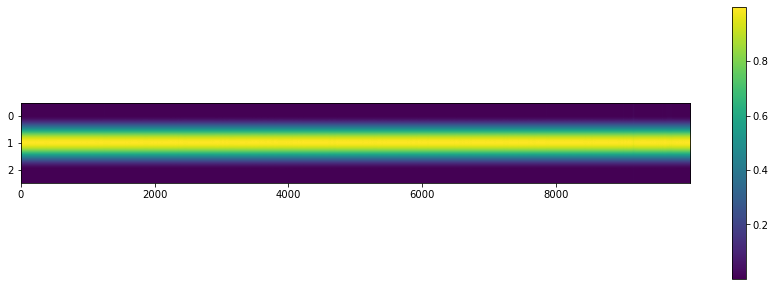

In [9]:
plt.figure(figsize = (15,5))
plt.imshow(Z_enc[0,16000:26000,0,:].cpu().detach().numpy().T, aspect=400)
plt.colorbar()

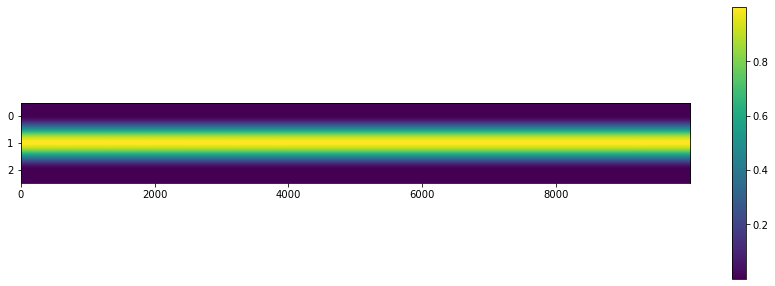

In [10]:
plt.figure(figsize = (15,5))
plt.imshow(Z_est[0,16000:26000,0,:].cpu().detach().numpy().T, aspect=400)
plt.colorbar()

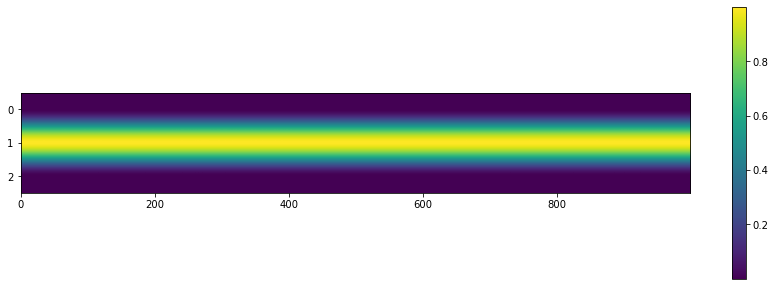

In [11]:
plt.figure(figsize = (15,5))
plt.imshow(Z_est[0,18000:19000,0,:].cpu().detach().numpy().T, aspect=50)
plt.colorbar()

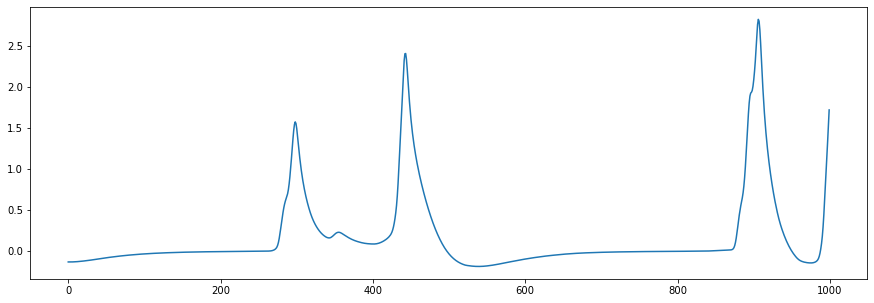

In [12]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[18000:19000])
plt.plot(test_V_pred.flatten().cpu().detach().numpy()[18000:19000])

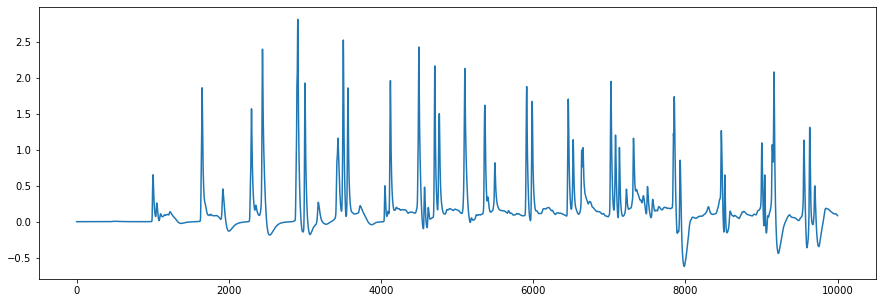

In [13]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.flatten().cpu().detach().numpy()[16000:26000])

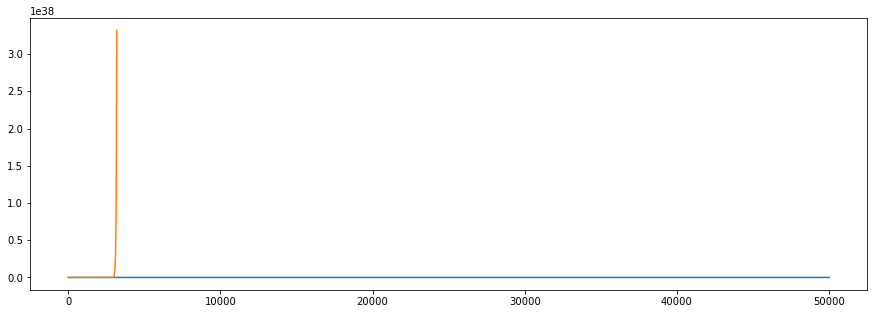

In [14]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.flatten().cpu().detach().numpy())

In [15]:
Z_out = np.zeros((50000,4))

for t in range(50000):
    for n in range(4):
        Z_out[t,n] = torch.argmax(test_Z[0,t,n])

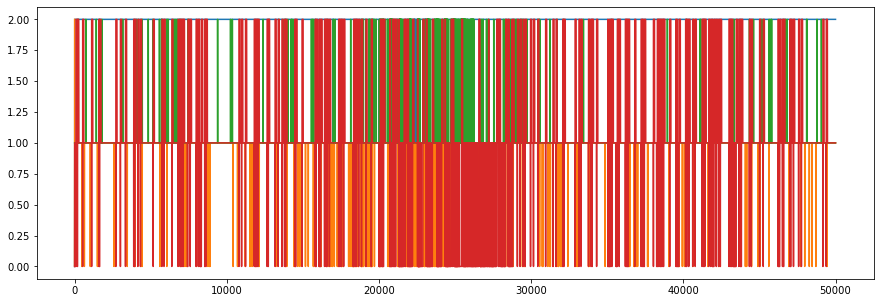

In [14]:
plt.figure(figsize = (15,5))

for n in range(4):
    plt.plot(Z_out[:,n])

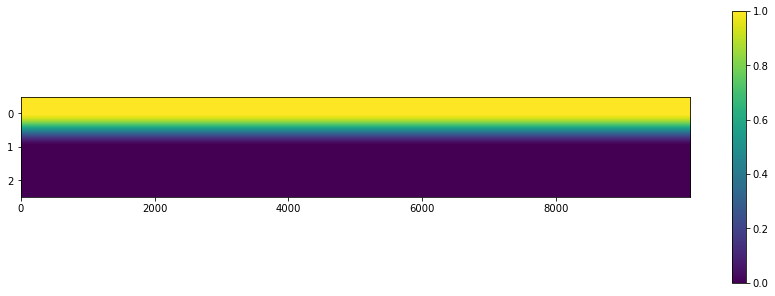

In [25]:
plt.figure(figsize = (15,5))
plt.imshow(test_Z[0,16000:26000,0].cpu().detach().numpy().T, aspect=500)
plt.colorbar()